2025-09-01 15:45:25.444511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Label mapping: {'Invalid': 0, 'Valid': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

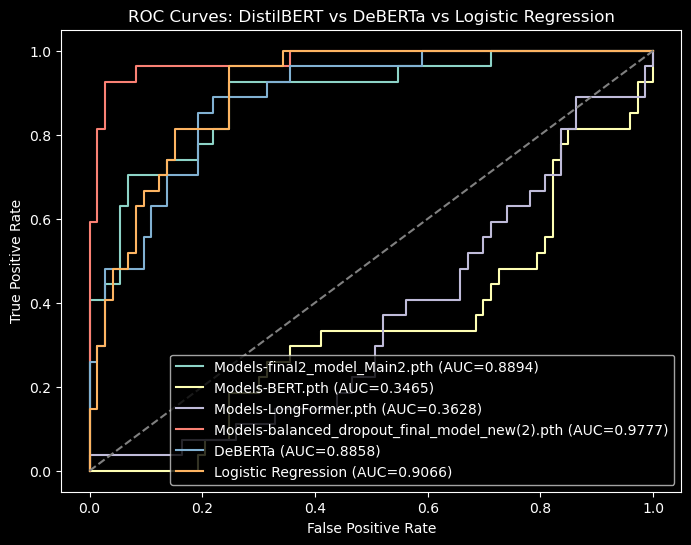

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import joblib

article_df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/Deliverables/codes/Main_Dataset3.csv')

# Fix randomness
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Encode labels
le = LabelEncoder()
article_df['MATCH_LABELS_ENCODED'] = le.fit_transform(article_df['MATCH_LABELS'])
article_df_small = article_df.sample(n=500, random_state=42).reset_index(drop=True)

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

class BiasDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

texts = (
    article_df_small['cleaned_content'].fillna('') + " "
    + article_df_small['entities_Group'].fillna('').astype(str) + " "
    + article_df_small['Actions'].fillna('').astype(str) + " "
    + article_df_small['Key_Phrases'].fillna('').astype(str)
).tolist()
labels = article_df_small['MATCH_LABELS_ENCODED'].tolist()

train_data, val_data, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_transformer(model_name, model_path, val_data, val_labels, label):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    val_dataset = BiasDataset(val_data, val_labels, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=data_collator)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
    state_dict = torch.load(model_path, map_location=device)
    if list(state_dict.keys())[0].startswith("omissionmodel."):
        state_dict = {k.replace("omissionmodel.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()

    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_batch = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1]

            all_labels.extend(labels_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs, pos_label=1)
    auc_score = roc_auc_score(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.4f})")


def eval_logreg(pipeline_path, val_data, val_labels, label):
    pipeline = joblib.load(pipeline_path)  # contains vectorizer + model
    probs = pipeline.predict_proba(val_data)[:, 1]

    fpr, tpr, _ = roc_curve(val_labels, probs, pos_label=1)
    auc_score = roc_auc_score(val_labels, probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.4f})")

plt.figure(figsize=(8, 6))

# DistilBERT models
distilbert_folder = "/Users/amalkurian/Desktop/Dissertation/Bias Detection/models/DistilBERT"
for model_file in os.listdir(distilbert_folder):
    if model_file.endswith(".pth"):
        eval_transformer(
            "distilbert-base-uncased",
            os.path.join(distilbert_folder, model_file),
            val_data, val_labels,
            f"Models-{model_file}"
        )

# DeBERTa
deberta_path = "/Users/amalkurian/Desktop/Dissertation/Bias Detection/models/DebertaV2/Deberta_final_model.pth"
eval_transformer("microsoft/deberta-v3-small", deberta_path, val_data, val_labels, "DeBERTa")

# Logistic Regression (pipeline)
logreg_path = "/Users/amalkurian/Desktop/Dissertation/Bias Detection/models/DistilBERT/logistic_regression_model.pkl"
eval_logreg(logreg_path, val_data, val_labels, "Logistic Regression")

# Finalize plot
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: DistilBERT vs DeBERTa vs Logistic Regression")
plt.legend(loc="lower right")
plt.show()


In [ ]:
microsoft/deberta-v3-small